# Classifying personality types : 1 letter

As you will see down below, this does NOT work at all. Whatsoever. 

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandasql as sql

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix


from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.semi_supervised import SelfTrainingClassifier
from pandasql import sqldf
from sklearn.base import BaseEstimator, TransformerMixin
import Levenshtein
import seaborn as sns


In [3]:
db_f_activities = pd.read_pickle('db_exploitable.pkl')
display(db_f_activities)

report_title  \
0                         10 Daily Activities   
1                            Daily activities   
2                          9 daily activities   
3                         10 daily activities   
4                         10 Daily Activities   
..                                        ...   
122                       10 Daily Activities   
123                       10 Daily Activities   
124                       10 Daily Activities   
125  10 daily activities - TypeLAB Japan 2024   
126                       10 Daily Activities   

                                              channels hand_preference  \
0    ["CZ","FZ","FPZ","FP1","F7","F3","FC1","C3","F...           RIGHT   
1    ["CZ","FZ","FPZ","FP1","F7","F3","FC1","C3","F...            LEFT   
2    ["CZ","FZ","FPZ","FP1","F7","F3","FC1","C3","F...           RIGHT   
3    ["CZ","FZ","FPZ","FP1","F7","F3","FC1","C3","F...           RIGHT   
4    ["CZ","FZ","FPZ","FP1","F7","F3","FC1","C3","F...           RIGHT   
..                                                 ...             ...   
122  ["CZ","FZ","FPZ","FP1","F7","F3","FC1","C3","F...           RIGHT   
123  ["CZ","FZ","FPZ","FP1","F7","F3","FC1","C3","F...           RIGHT   
124  ["CZ","FZ","FPZ","FP1","F7","F3","FC1","C3","F...            LEFT   
125  ["CZ","FZ","FPZ","FP1","F7","F3","FC1","C3","F...           RIGHT   
126  ["CZ","FZ","FPZ","FP1","F7","F3","FC1","C3","F...            None   

    mbti_type     analysis_version frequency_bandwidths executive_style  \
0        INTP  2001-02-01 00:00:00           ["0.5:45"]       ENERGIZER   
1        None  2001-02-01 00:00:00           ["0.5:45"]       ENERGIZER   
2        INTP  2001-02-01 00:00:00           ["0.5:45"]         REFINER   
3        None  2001-02-01 00:00:00           ["0.5:45"]         REFINER   
4        INFJ  2001-02-01 00:00:00           ["0.5:45"]         REFINER   
..        ...                  ...                  ...             ...   
122      ENFP  2001-02-01 00:00:00           ["0.5:45"]       ENERGIZER   
123      INTJ  2001-02-01 00:00:00           ["0.5:45"]         REFINER   
124      ESTJ  2000-02-01 00:00:00           ["0.5:45"]         REFINER   
125      INTJ  2001-02-01 00:00:00           ["0.5:45"]       CONNECTOR   
126      None  2001-02-01 00:00:00           ["0.5:45"]       EXPEDITER   

                                          top_patterns  \
0            ["STRONG_STARBURST","LEFT","CENTER_BACK"]   
1                   ["STRONG_STARBURST","LEFT","HALO"]   
2               ["CENTER_FRONT","CENTER_BACK","RIGHT"]   
3                        ["BACK","LEFT","CENTER_BACK"]   
4                   ["BACK","HALO","HIDDEN_STARBURST"]   
..                                                 ...   
122  ["STRONG_STARBURST","RANDOM_FIELD","AUDIO_KINE...   
123                     ["LEFT","HALO","CENTER_FRONT"]   
124              ["FOCUSED_HOLISTIC","LEFT","DIAMOND"]   
125      ["DIAMONDS","SUPER_AUDIO","FOCUSED_HOLISTIC"]   
126                    ["HALO","FRONT","CENTER_FRONT"]   

                             top_skills  average_circuit_hits_decision_making  \
0    ["O1","PO7","P8","O2","CP6","PO8"]                                 53371   
1     ["O1","PO7","P7","FT9","T7","O2"]                                 49629   
2      ["T8","PO8","P8","P7","O2","T7"]                                 37356   
3    ["P7","PO7","P8","PO8","O1","FT9"]                                 35679   
4    ["O1","PO7","O2","PO8","P7","FT9"]                                 69148   
..                                  ...                                   ...   
122   ["T7","T8","O2","FT9","P7","PO8"]                                 47347   
123   ["FT9","O1","PO7","P7","O2","T7"]                                 45026   
124  ["PO7","O1","P7","FT9","PO8","O2"]                                 39630   
125  ["T7","FC2","T8","CP5","P8","FC5"]                                 75508   
126   ["O2","PO8","T7","O1","T8","PO7"]                           

In [4]:
# Step 1: Clean text columns
def clean_text_column(col):
    return col.apply(lambda x: ' '.join(x) if isinstance(x, list) else (str(x) if x is not None else '')).replace('', 'unknown')

db_f_activities['top_patterns_encoded'] = clean_text_column(db_f_activities['top_patterns_encoded'])
db_f_activities['top_skills_cleaned'] = clean_text_column(db_f_activities['top_skills_cleaned'])

# Step 2: Fix corrupted numeric columns (e.g., strings/dates in numeric columns)
# Convert to numeric safely
numeric_cols = [
    'average_circuit_hits_decision_making', 'average_circuit_hits_perception',
    'average_circuit_hits_abstract', 'average_circuit_hits_concrete',
    'average_circuit_hits_social', 'average_circuit_hits_technical'
]

for col in numeric_cols:
    db_f_activities[col] = pd.to_numeric(db_f_activities[col], errors='coerce')

# Step 3: Remove rows with NaN in any of the numeric columns
query = """
SELECT average_circuit_hits_abstract, 
    average_circuit_hits_concrete,
    average_circuit_hits_social,
    average_circuit_hits_technical,
    average_circuit_hits_decision_making,
    average_circuit_hits_perception,
    top_patterns_encoded, 
    top_skills_cleaned, 
    mbti_type
FROM db_f_activities
WHERE 
    average_circuit_hits_abstract IS NOT NULL AND
    average_circuit_hits_concrete IS NOT NULL AND
    average_circuit_hits_social IS NOT NULL AND
    average_circuit_hits_technical IS NOT NULL AND
    average_circuit_hits_decision_making IS NOT NULL AND
    average_circuit_hits_perception IS NOT NULL
"""
db_f_activities_clean = sqldf(query)

In [5]:
# Step 4: Separate labeled and unlabeled
labeled_df = db_f_activities_clean[db_f_activities_clean['mbti_type'].notnull()]
unlabeled_df = db_f_activities_clean[db_f_activities_clean['mbti_type'].isnull()]

# Step 5: Define preprocessing pipelines
text_pipeline = TfidfVectorizer()
num_pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())


# First letter : E/I

In [6]:
# --- Custom Levenshtein distance transformer ---
class LevenshteinVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, reference=None):
        self.reference = reference

    def fit(self, X, y=None):
        self.reference = pd.Series(X.values.ravel()).dropna().unique().tolist()
        return self

    def transform(self, X):
        return np.array([
            [Levenshtein.distance(str(x), str(ref)) for ref in self.reference]
            for x in X.values.ravel()
        ])

/var/folders/88/zqbc622x5tb8f2bkxq6dd4h00000gn/T/ipykernel_6657/1699736950.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_df['ei_label'] = labeled_df['mbti_type'].str[0]  # Extract only 'E' or 'I'


Classification Report (E vs. I):
              precision    recall  f1-score   support

           E       0.38      0.33      0.36        39
           I       0.46      0.51      0.48        43

    accuracy                           0.43        82
   macro avg       0.42      0.42      0.42        82
weighted avg       0.42      0.43      0.42        82

Confusion Matrix (E vs. I):
[[13 26]
 [21 22]]


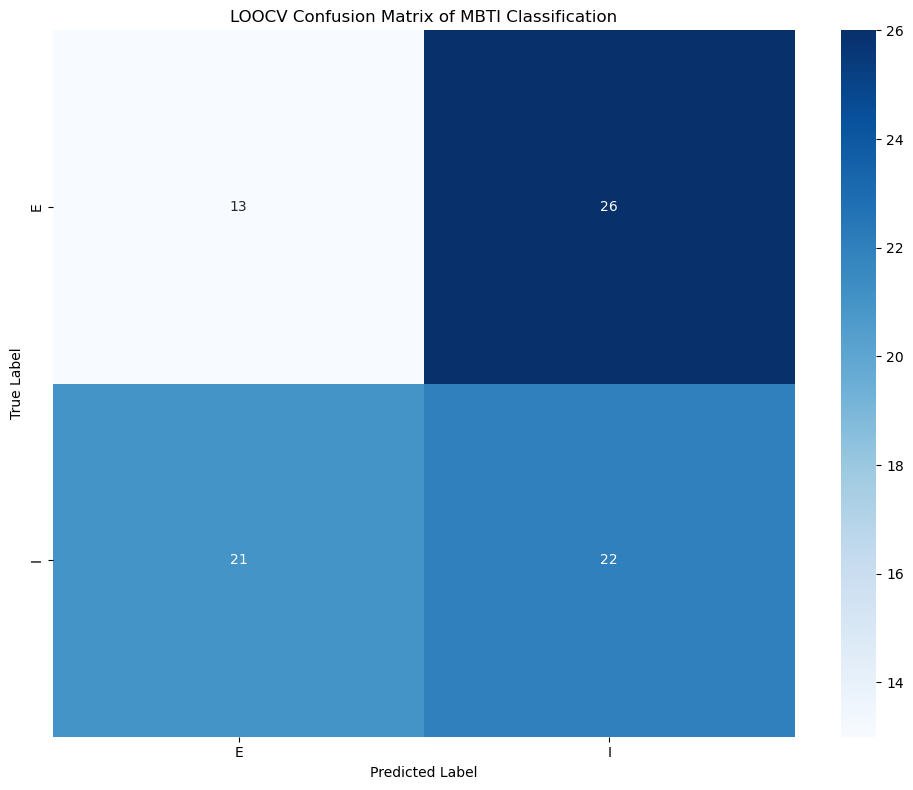

In [10]:
# --- Extract E/I label ---
labeled_df['ei_label'] = labeled_df['mbti_type'].str[0]  # Extract only 'E' or 'I'

# --- Features and labels ---
X = labeled_df.drop(columns=['mbti_type', 'ei_label'])
y = labeled_df['ei_label']
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()

# --- Preprocessing ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numeric_cols),
        ('patterns_lev', Pipeline([
            ('lev', LevenshteinVectorizer())
        ]), 'top_patterns_encoded'),
        ('skills_lev', Pipeline([
            ('lev', LevenshteinVectorizer())
        ]), 'top_skills_cleaned'),
    ],
    remainder='drop'
)

# --- Classifier pipeline ---
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# --- Leave-One-Out CV ---
loo = LeaveOneOut()
y_true, y_pred = [], []

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    clf_pipeline.fit(X_train, y_train)
    pred = clf_pipeline.predict(X_test)
    
    y_true.append(y_test.values[0])
    y_pred.append(pred[0])

# --- Evaluation ---
print("Classification Report (E vs. I):")
print(classification_report(y_true, y_pred))

print("Confusion Matrix (E vs. I):")
print(confusion_matrix(y_true, y_pred))

# Confusion matrix
X_labeled = preprocessor.fit_transform(labeled_df)

labels = np.unique(y)
cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('LOOCV Confusion Matrix of MBTI Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Second letter : N/S

/var/folders/88/zqbc622x5tb8f2bkxq6dd4h00000gn/T/ipykernel_6657/2951022782.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_df['ei_label'] = labeled_df['mbti_type'].str[1]  # Extract only 'N' or 'S'


Classification Report (N vs. S):
              precision    recall  f1-score   support

           N       0.74      0.88      0.81        59
           S       0.42      0.22      0.29        23

    accuracy                           0.70        82
   macro avg       0.58      0.55      0.55        82
weighted avg       0.65      0.70      0.66        82

Confusion Matrix (N vs. S):
[[52  7]
 [18  5]]


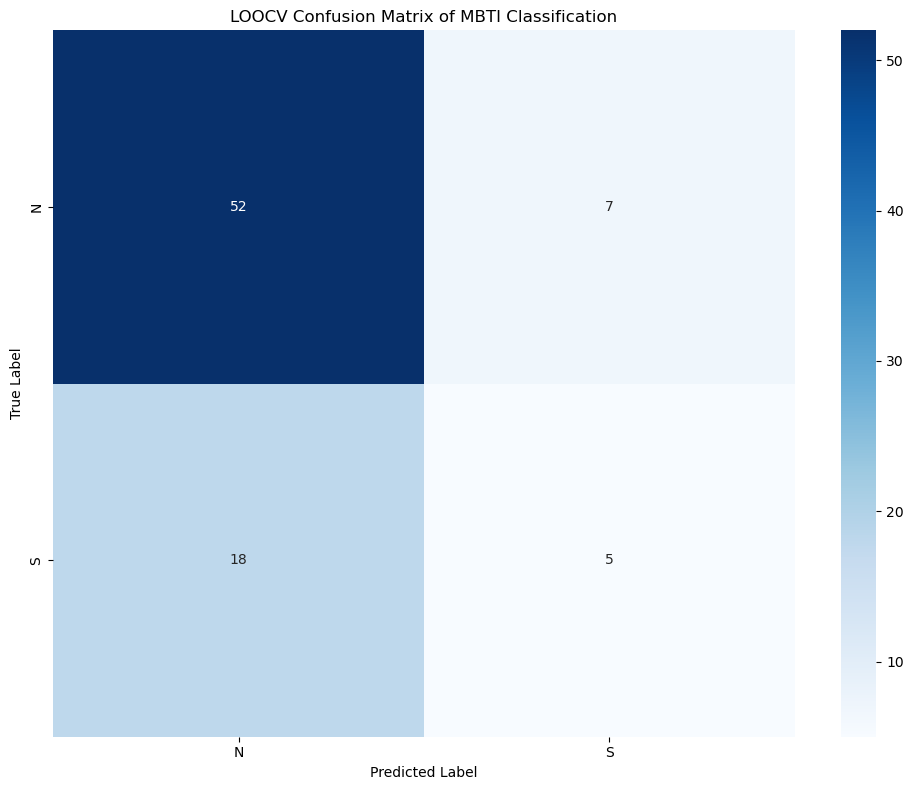

In [11]:
# --- Extract E/I label ---
labeled_df['ei_label'] = labeled_df['mbti_type'].str[1]  # Extract only 'N' or 'S'

# Features and labels
X = labeled_df.drop(columns=['mbti_type', 'ei_label'])
y = labeled_df['ei_label']

# Get numeric columns
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numeric_cols),
        ('patterns_lev', Pipeline([
            ('lev', LevenshteinVectorizer())
        ]), 'top_patterns_encoded'),
        ('skills_lev', Pipeline([
            ('lev', LevenshteinVectorizer())
        ]), 'top_skills_cleaned'),
    ],
    remainder='drop'
)

# Classifier pipeline
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Leave-One-Out Cross-Validation
loo = LeaveOneOut()
y_true, y_pred = [], []

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    clf_pipeline.fit(X_train, y_train)
    pred = clf_pipeline.predict(X_test)
    
    y_true.append(y_test.values[0])
    y_pred.append(pred[0])

# Evaluation
print("Classification Report (N vs. S):")
print(classification_report(y_true, y_pred))

print("Confusion Matrix (N vs. S):")
print(confusion_matrix(y_true, y_pred))

# Confusion matrix
X_labeled = preprocessor.fit_transform(labeled_df)

labels = np.unique(y)
cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('LOOCV Confusion Matrix of MBTI Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Third letter : T/F

In [12]:
# --- Extract E/I label ---
labeled_df['ei_label'] = labeled_df['mbti_type'].str[2]  # Extract only 'T' or 'F'

# Features and labels
X = labeled_df.drop(columns=['mbti_type', 'ei_label'])
y = labeled_df['ei_label']

# Get numeric columns
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numeric_cols),
        ('patterns_lev', Pipeline([
            ('lev', LevenshteinVectorizer())
        ]), 'top_patterns_encoded'),
        ('skills_lev', Pipeline([
            ('lev', LevenshteinVectorizer())
        ]), 'top_skills_cleaned'),
    ],
    remainder='drop'
)

# Classifier pipeline
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Leave-One-Out Cross-Validation
loo = LeaveOneOut()
y_true, y_pred = [], []

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    clf_pipeline.fit(X_train, y_train)
    pred = clf_pipeline.predict(X_test)
    
    y_true.append(y_test.values[0])
    y_pred.append(pred[0])

# Evaluation
print("Classification Report (T vs. F):")
print(classification_report(y_true, y_pred))

print("Confusion Matrix (T vs. F):")
print(confusion_matrix(y_true, y_pred))

# Confusion matrix
X_labeled = preprocessor.fit_transform(labeled_df)

labels = np.unique(y)
cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('LOOCV Confusion Matrix of MBTI Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

/var/folders/88/zqbc622x5tb8f2bkxq6dd4h00000gn/T/ipykernel_6657/1726884901.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_df['ei_label'] = labeled_df['mbti_type'].str[2]  # Extract only 'T' or 'F'


Classification Report (T vs. F):
              precision    recall  f1-score   support

           F       0.48      0.42      0.45        36
           T       0.59      0.65      0.62        46

    accuracy                           0.55        82
   macro avg       0.54      0.53      0.53        82
weighted avg       0.54      0.55      0.54        82

Confusion Matrix (T vs. F):
[[15 21]
 [16 30]]


# Fourth letter : P/J

In [13]:
# --- Extract E/I label ---
labeled_df['ei_label'] = labeled_df['mbti_type'].str[3]  # Extract only 'P' or 'J'

# Features and labels
X = labeled_df.drop(columns=['mbti_type', 'ei_label'])
y = labeled_df['ei_label']

# Get numeric columns
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numeric_cols),
        ('patterns_lev', Pipeline([
            ('lev', LevenshteinVectorizer())
        ]), 'top_patterns_encoded'),
        ('skills_lev', Pipeline([
            ('lev', LevenshteinVectorizer())
        ]), 'top_skills_cleaned'),
    ],
    remainder='drop'
)

# Classifier pipeline
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Leave-One-Out Cross-Validation
loo = LeaveOneOut()
y_true, y_pred = [], []

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    clf_pipeline.fit(X_train, y_train)
    pred = clf_pipeline.predict(X_test)
    
    y_true.append(y_test.values[0])
    y_pred.append(pred[0])

# Evaluation
print("Classification Report (P vs. J):")
print(classification_report(y_true, y_pred))

print("Confusion Matrix P vs. J):")
print(confusion_matrix(y_true, y_pred))

# Confusion matrix
X_labeled = preprocessor.fit_transform(labeled_df)

labels = np.unique(y)
cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('LOOCV Confusion Matrix of MBTI Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

/var/folders/88/zqbc622x5tb8f2bkxq6dd4h00000gn/T/ipykernel_6657/2248008312.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_df['ei_label'] = labeled_df['mbti_type'].str[3]  # Extract only 'P' or 'J'


Classification Report (P vs. J):
              precision    recall  f1-score   support

           J       0.63      0.76      0.69        45
           P       0.61      0.46      0.52        37

    accuracy                           0.62        82
   macro avg       0.62      0.61      0.60        82
weighted avg       0.62      0.62      0.61        82

Confusion Matrix P vs. J):
[[34 11]
 [20 17]]
